# E-Commerce Customers' Product Purchase Forecast

### Purpose of Data Analysis
- Clustering based on user's purchase pattern by analyzing E-Commerce users
- Use the results of clustering for future marketing and recommendations

In [1]:
# libraries for feature engineering and EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from IPython.display import Image
from datetime import datetime
import random
import pandas_profiling

# libraries for statistic
from scipy import stats
from scipy.stats import skew
from scipy.stats import kurtosis


# libraries for machine learning
from sklearn.cluster import KMeans

%matplotlib inline

C:\Users\wlgus\AppData\Local\Temp\ipykernel_20144\3064576380.py:11: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


## 1. Data Processing 1 

### 1-1 Data Load 

In [2]:
df = pd.read_csv('./2019-Nov_sample_10percent.csv')
df.head()

,Unnamed: 0,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,42912469,2019-11-17 12:55:27 UTC,view,1801940,2053013554415534427,electronics.video.tv,haier,231.64,557260014,9eae31f2-7728-4a63-8ec1-214fa7b1a913
1,33404333,2019-11-16 04:44:35 UTC,view,100003663,2053013557133443581,furniture.living_room.cabinet,stendmebel,430.87,532931161,356b963b-ac2a-43cc-9ad2-c9f5eaadcb60
2,28620112,2019-11-15 08:43:53 UTC,view,1004249,2053013555631882655,electronics.smartphone,apple,739.04,550988096,aa13bf9c-1e22-405d-a5f0-3803ffe546c8
3,8744840,2019-11-06 10:21:52 UTC,view,3701134,2053013565983425517,appliances.environment.vacuum,bosch,115.81,560410260,97b64f35-ee84-4732-bfc9-78a1b4bc1426
4,58422604,2019-11-25 15:12:34 UTC,view,1004505,2053013555631882655,electronics.smartphone,xiaomi,514.56,516687754,8f147c20-c958-49b9-a391-c27eecf56fb0


### 1-2 Remove Unnecessary Data

In [3]:
df = df.drop(columns=["Unnamed: 0"])

In [4]:
df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

### 1-3 Check Duplicated Data

In [5]:
print("the number of duplicated data :", len(df[df.duplicated()])) 

the number of duplicated data : 1999


In [6]:
df = df.drop_duplicates()

In [7]:
df = df.reset_index(drop=True)

In [8]:
print("the number of duplicated data :", len(df[df.duplicated()])) 

the number of duplicated data : 0


## 2. Data EDA

### 2-1 Data Type and Summary

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6748199 entries, 0 to 6748198
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 463.4+ MB


In [10]:
# categorical and numeric columns
for column_name in list(df.columns):
    print(column_name, df[column_name].dtype, df[column_name].unique())

event_time object ['2019-11-17 12:55:27 UTC' '2019-11-16 04:44:35 UTC'
 '2019-11-15 08:43:53 UTC' ... '2019-11-11 22:57:52 UTC'
 '2019-11-22 19:42:54 UTC' '2019-11-03 12:10:06 UTC']
event_type object ['view' 'cart' 'purchase']
product_id int64 [  1801940 100003663   1004249 ... 100005293  13800335 100010746]
category_id int64 [2053013554415534427 2053013557133443581 2053013555631882655
 2053013565983425517 2053013566176363511 2053013554591695207
 2053013554776244595 2053013557166998015 2053013555573162395
 2053013563651392361 2134905044833666047 2053013558920217191
 2053013563911439225 2053013563693335403 2053013563173241677
 2053013554658804075 2053013563584283495 2061717937420501730
 2135658542386905834 2053013564003713919 2053013553056579841
 2053013557024391671 2053013566243472379 2053013563944993659
 2053013552863641845 2053013557192163841 2053013565069067197
 2053013555262783879 2053013564918072245 2053013553912217915
 2053013553341792533 2053013556227473861 2053013560144954031
 

In [11]:
# categorical -> object
# Check unique value and data description together, make a decision heuristicly

list_casting_as_object = ["product_id", "category_id", "user_id"]
for column_name in list_casting_as_object:
  df[column_name] = df[column_name].astype("string")

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6748199 entries, 0 to 6748198
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     string 
 3   category_id    string 
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        string 
 8   user_session   object 
dtypes: float64(1), object(5), string(3)
memory usage: 463.4+ MB


In [13]:
list_categorical_columns = list(df.select_dtypes(include=['string','object']).columns)
list_numeric_columns = list(df.select_dtypes(include=['float64']).columns)
target_column = "shares"
print(len(df.columns))
print(len(list_categorical_columns))
print(len(list_numeric_columns))

9
8
1


In [14]:
df.columns[df.isna().sum() != 0]

Index(['category_code', 'brand'], dtype='object')

#### Summary of Data Set
##### - Number of Variables : 9
    categorical variables : 8
    numeric variables : 1
##### - Number of observations : 6748199
##### - Missing Cells : 2 columns
##### - Duplicated Rows : 1999 (removed)

### 2-2 Independent Data Explore

#### 1) Categorical Data Analysis

##### Check unnecessary columns

In [15]:
df[list_categorical_columns].nunique().sort_values() 

event_type             3
category_code        127
category_id          674
brand               3911
product_id        149323
user_id          1830972
event_time       2022083
user_session     4246753
dtype: int64

In [16]:
# Remove category_id (similar to category_code)
# Remove brand, product_id, event_time, user_session
column_removed = ["category_id", "brand", "product_id", "event_time", "user_session"]
df = df.drop(column_removed, axis=1)

In [17]:
for column in column_removed:
    list_categorical_columns.remove(column)

In [18]:
df = df[df["event_type"] == "purchase"]

In [19]:
display(df)

,event_type,category_code,price,user_id
199,purchase,NaN,100.39,561394679
471,purchase,electronics.smartphone,255.57,530510565
487,purchase,NaN,85.71,567695354
651,purchase,electronics.smartphone,88.26,563648409
653,purchase,electronics.smartphone,1029.09,560198101
...,...,...,...,...
6747592,purchase,electronics.audio.headphone,25.69,575990174
6747762,purchase,NaN,36.04,572523941
6747799,purchase,electronics.smartphone,104.93,550413435
6747830,purchase,appliances.kitchen.juicer,128.68,575871876


In [20]:
df.isna().sum()

event_type           0
category_code    23474
price                0
user_id              0
dtype: int64

In [21]:
df_filtered = df.dropna().reset_index(drop=True)

In [22]:
df_filtered["category_code_1st"] = df_filtered["category_code"].apply(lambda x : x.split(".")[0])
df_filtered["category_code_2nd"] = df_filtered["category_code"].apply(lambda x : x.split(".")[1])

In [23]:
list_categorical_columns.append("category_code_1st")
list_categorical_columns.append("category_code_2nd")

In [24]:
df_filtered.nunique()

event_type               1
category_code          120
price                 8770
user_id              57292
category_code_1st       13
category_code_2nd       54
dtype: int64

<Axes: xlabel='category_code', ylabel='Count'>

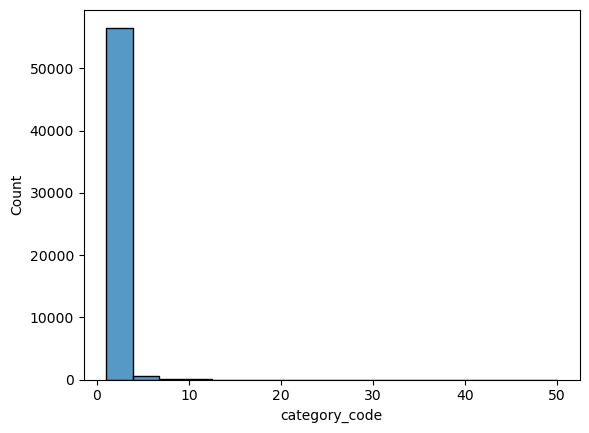

In [25]:
sns.histplot(df_filtered.groupby("user_id").count()["category_code"])

In [26]:
display(df_filtered)

,event_type,category_code,price,user_id,category_code_1st,category_code_2nd
0,purchase,electronics.smartphone,255.57,530510565,electronics,smartphone
1,purchase,electronics.smartphone,88.26,563648409,electronics,smartphone
2,purchase,electronics.smartphone,1029.09,560198101,electronics,smartphone
3,purchase,electronics.video.tv,694.17,572466923,electronics,video
4,purchase,electronics.smartphone,179.16,547251428,electronics,smartphone
...,...,...,...,...,...,...
68068,purchase,electronics.smartphone,136.71,572142479,electronics,smartphone
68069,purchase,electronics.audio.headphone,25.69,575990174,electronics,audio
68070,purchase,electronics.smartphone,104.93,550413435,electronics,smartphone
68071,purchase,appliances.kitchen.juicer,128.68,575871876,appliances,kitchen


In [27]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68073 entries, 0 to 68072
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   event_type         68073 non-null  object 
 1   category_code      68073 non-null  object 
 2   price              68073 non-null  float64
 3   user_id            68073 non-null  string 
 4   category_code_1st  68073 non-null  object 
 5   category_code_2nd  68073 non-null  object 
dtypes: float64(1), object(4), string(1)
memory usage: 3.1+ MB


##### Check distribution by columns

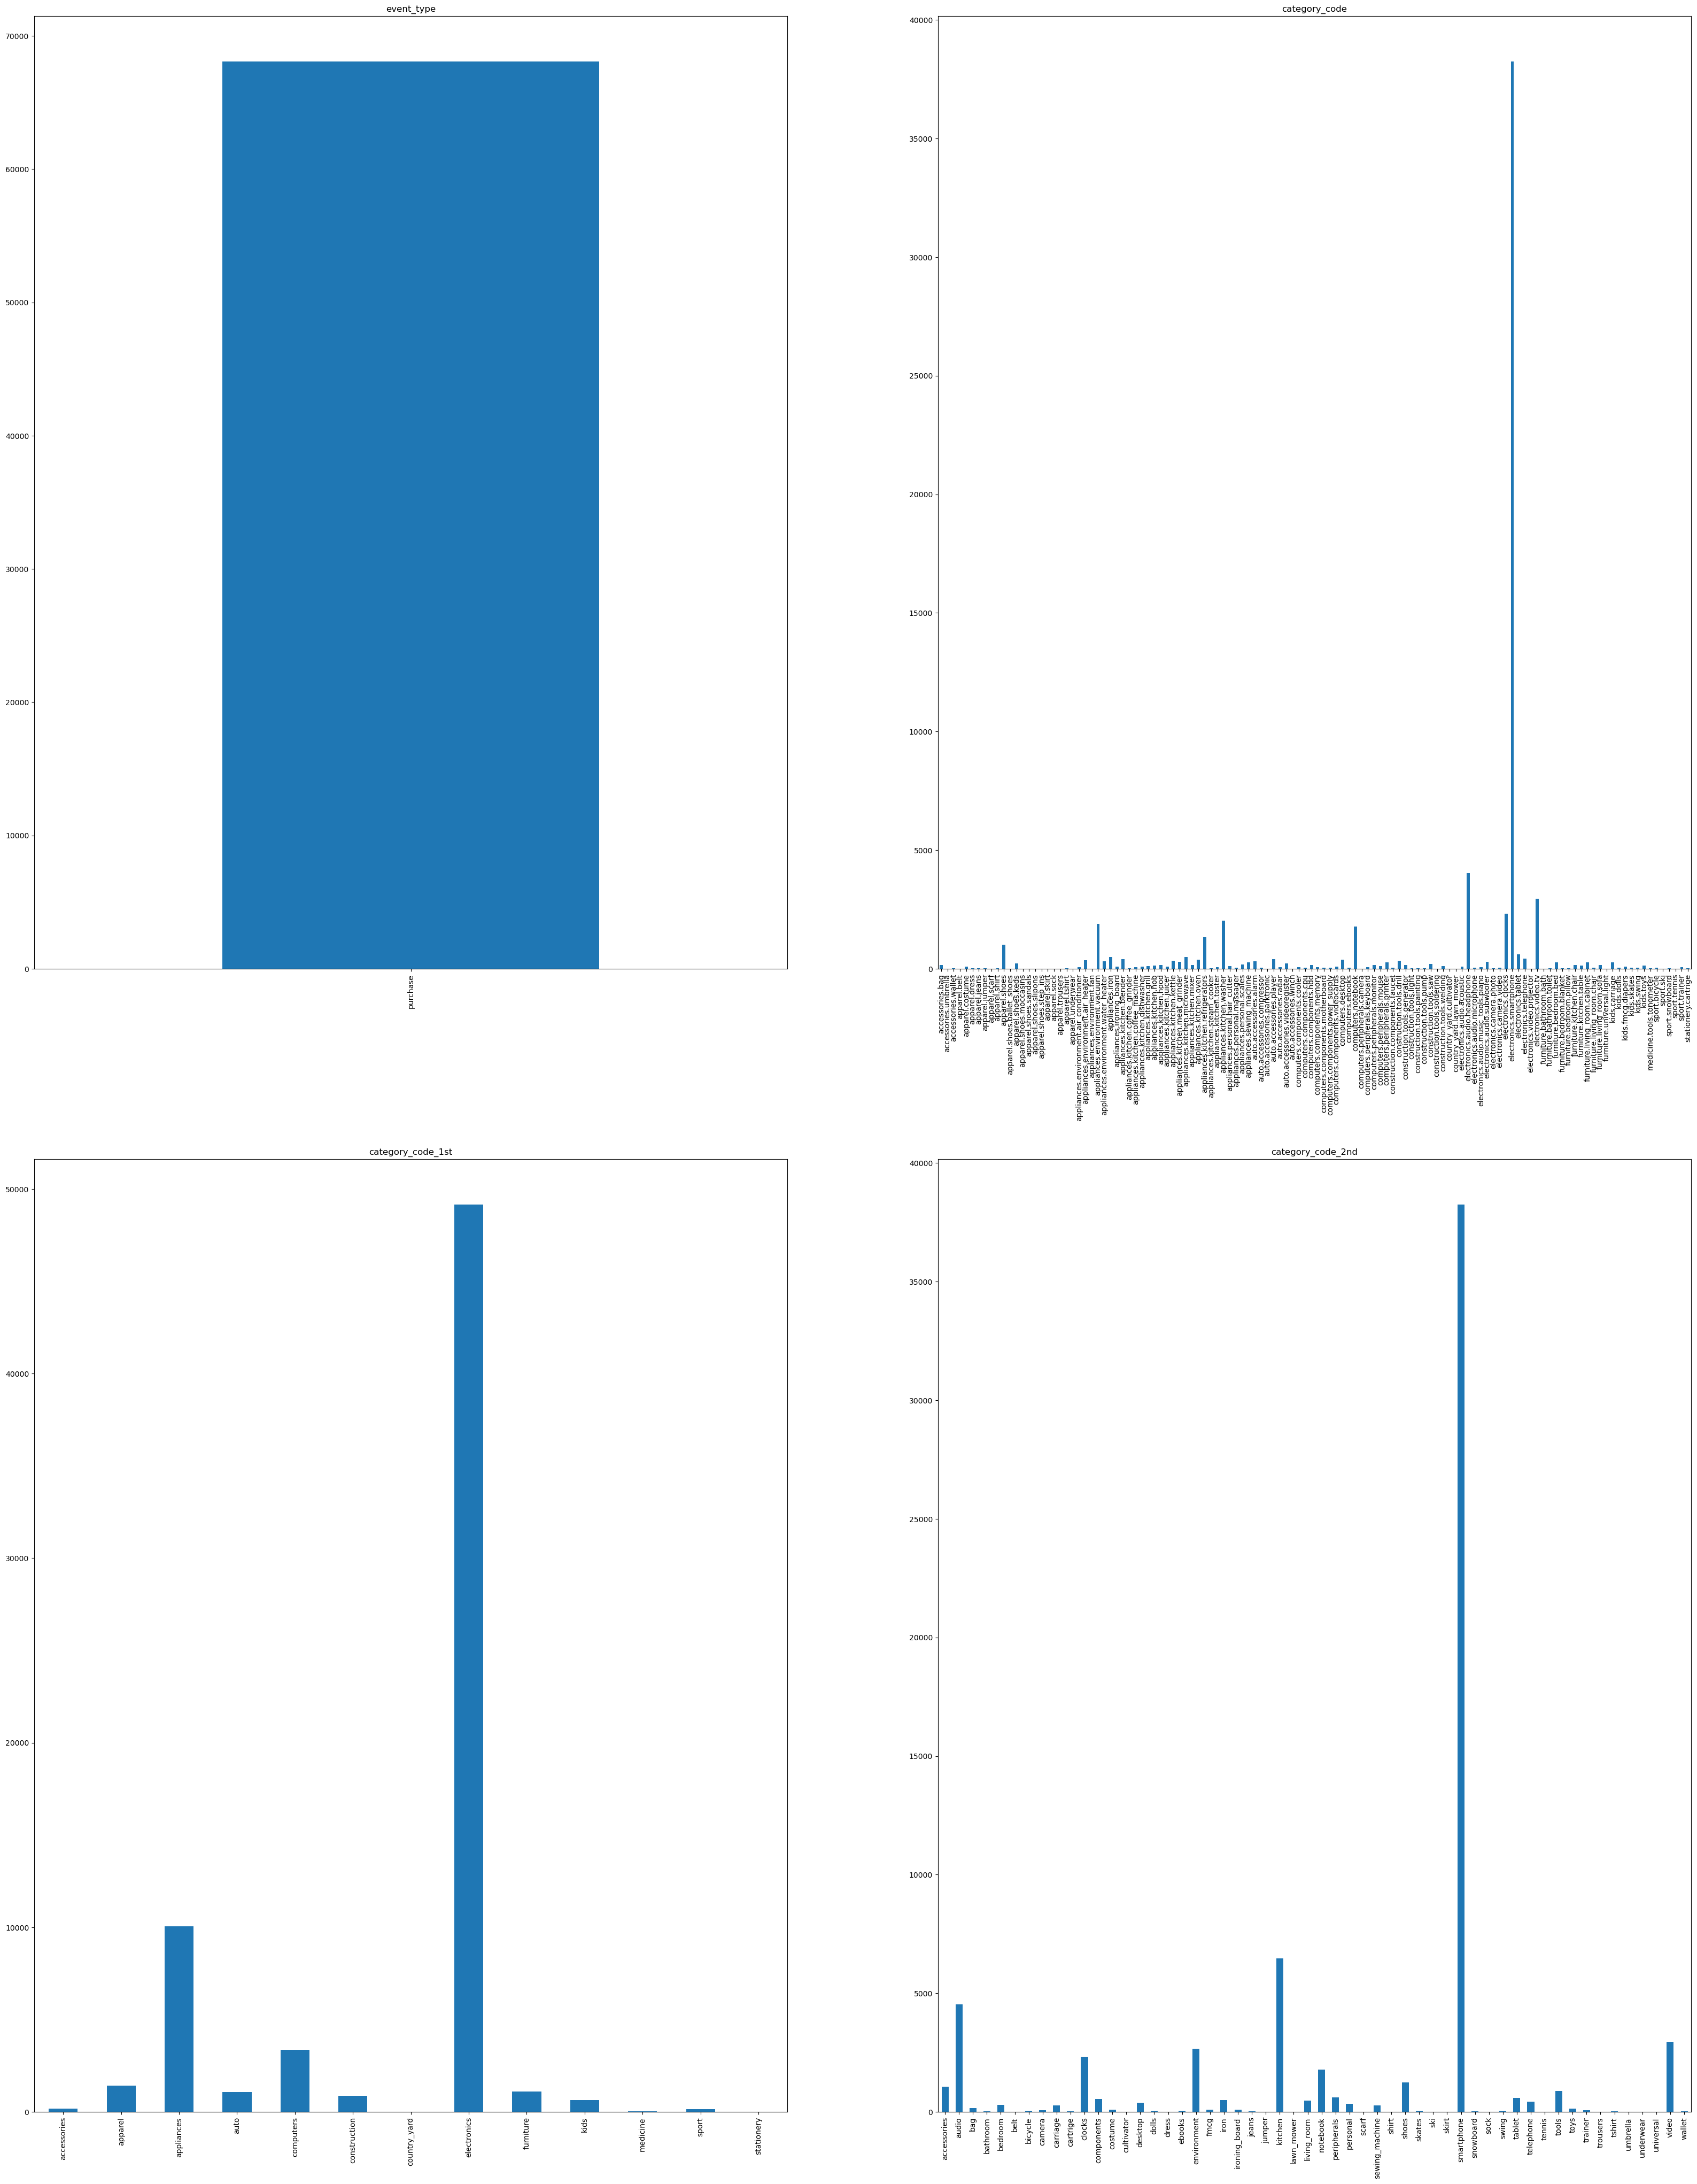

In [28]:
# Check distribution by cateogircla column
plt.figure(figsize=(40,40))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2, wspace=0.2)
for column_name in list_categorical_columns:
    if column_name == "user_id":
        continue
    plt.subplot(2,2,x)
    x = x+1
    df_filtered[column_name].value_counts().sort_index().plot(kind='bar')
    plt.title(column_name)
plt.show()

#### Insight
- If there are too many categories, it is hard to see the graph (2nd graph) . So, I did split the categories, and as you see the 3rd and 4th graph, 'electronics' is sold the most. In detail, 'smartphone' is sold the most, followed by 'kitchen'

#### 2) Numeric Data Analysis

##### Check unnecessary columns

In [30]:
df[list_numeric_columns].nunique().sort_values()

price    11584
dtype: int64

##### Check distribution by columns

In [31]:
df["price"].describe()

count    91547.000000
mean       300.111189
std        341.639659
min          0.870000
25%         82.840000
50%        169.920000
75%        362.100000
max       2574.070000
Name: price, dtype: float64

<Axes: >

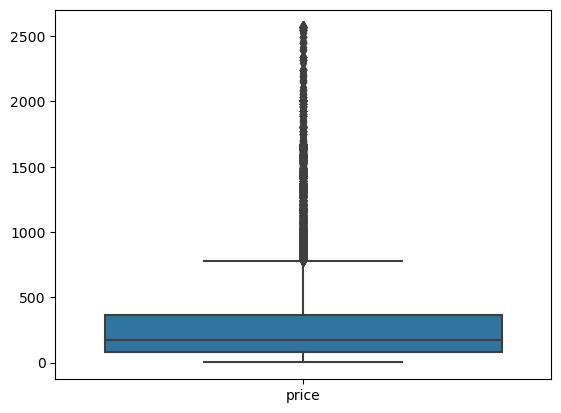

In [32]:
sns.boxplot(df[list_numeric_columns])

In [36]:
for column_name in list_numeric_columns:
  print(column_name, "skew : ", skew(df[column_name]), "kur : ", kurtosis(df[column_name]) )
  
# Found out to need to do feature preprocessing through scailing

price skew :  2.1110804586090732 kur :  4.943002067732956


### 2-4 EDA with pandas_profiling 

In [37]:
path = "./data/"

In [39]:
df_filtered.profile_report().to_file(path + "data_eda_with_pandasprofiling.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 3. Data Processing 2 

### 3-1 Missing Values

In [41]:
df_filtered.isna().sum().sort_values(ascending=False)

event_type           0
category_code        0
price                0
user_id              0
category_code_1st    0
category_code_2nd    0
dtype: int64

In [42]:
df_filtered

,event_type,category_code,price,user_id,category_code_1st,category_code_2nd
0,purchase,electronics.smartphone,255.57,530510565,electronics,smartphone
1,purchase,electronics.smartphone,88.26,563648409,electronics,smartphone
2,purchase,electronics.smartphone,1029.09,560198101,electronics,smartphone
3,purchase,electronics.video.tv,694.17,572466923,electronics,video
4,purchase,electronics.smartphone,179.16,547251428,electronics,smartphone
...,...,...,...,...,...,...
68068,purchase,electronics.smartphone,136.71,572142479,electronics,smartphone
68069,purchase,electronics.audio.headphone,25.69,575990174,electronics,audio
68070,purchase,electronics.smartphone,104.93,550413435,electronics,smartphone
68071,purchase,appliances.kitchen.juicer,128.68,575871876,appliances,kitchen


### 3-2 Feature Engineering

In [43]:
df_filtered_pivot = df_filtered.pivot_table(index=df_filtered.index, columns='category_code_1st', values=["price", "price"], aggfunc=["first","count"]).fillna(0)

In [44]:
df_filtered_pivot.columns = ['_'.join(col) for col in df_filtered_pivot.columns.values]

In [45]:
df_filtered_pivot["user_id"] = df_filtered["user_id"]

In [46]:
df_filtered_pivot.head(2)

,first_price_accessories,first_price_apparel,first_price_appliances,first_price_auto,first_price_computers,first_price_construction,first_price_country_yard,first_price_electronics,first_price_furniture,first_price_kids,...,count_price_computers,count_price_construction,count_price_country_yard,count_price_electronics,count_price_furniture,count_price_kids,count_price_medicine,count_price_sport,count_price_stationery,user_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255.57,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,530510565
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.26,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,563648409


In [47]:
df_user_pivot = df_filtered_pivot.groupby("user_id").agg(sum)

### 3-3 Feature Transformation

In [48]:
df_user_pivot.head(1)

,first_price_accessories,first_price_apparel,first_price_appliances,first_price_auto,first_price_computers,first_price_construction,first_price_country_yard,first_price_electronics,first_price_furniture,first_price_kids,...,count_price_auto,count_price_computers,count_price_construction,count_price_country_yard,count_price_electronics,count_price_furniture,count_price_kids,count_price_medicine,count_price_sport,count_price_stationery
user_id,,,,,,,,,,,,,,,,,,,,,
225644257,0.0,0.0,0.0,0.0,40.91,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_user_pivot.loc[:, :] = scaler.fit_transform(df_user_pivot)
df_user_pivot.head()

,first_price_accessories,first_price_apparel,first_price_appliances,first_price_auto,first_price_computers,first_price_construction,first_price_country_yard,first_price_electronics,first_price_furniture,first_price_kids,...,count_price_auto,count_price_computers,count_price_construction,count_price_country_yard,count_price_electronics,count_price_furniture,count_price_kids,count_price_medicine,count_price_sport,count_price_stationery
user_id,,,,,,,,,,,,,,,,,,,,,
225644257,0.0,0.0,0.0,0.0,0.002869,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.111111,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0
315835876,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.006779,0.0,0.0,...,0.0,0.000000,0.00,0.0,0.02,0.0,0.0,0.0,0.0,0.0
435584787,0.0,0.0,0.0,0.0,0.000000,0.025491,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.25,0.0,0.00,0.0,0.0,0.0,0.0,0.0
448659331,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000358,0.0,0.0,...,0.0,0.000000,0.00,0.0,0.02,0.0,0.0,0.0,0.0,0.0
465378521,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.009243,0.0,0.0,...,0.0,0.000000,0.00,0.0,0.02,0.0,0.0,0.0,0.0,0.0


### 3-4 Summary
##### Final Features have the following characteristics
1.   pivoting by Main Category Data 
2.   aggregation by user_id

##### df_user_pivot

## 4. Model Analysis

In [52]:
sum_of_squared_distances = []
K = range(2,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_user_pivot)
    sum_of_squared_distances.append(km.inertia_)

C:\Users\wlgus\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\wlgus\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\wlgus\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\wlgus\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\wlgus\anaconda3\lib\site-packages\sklearn\clust

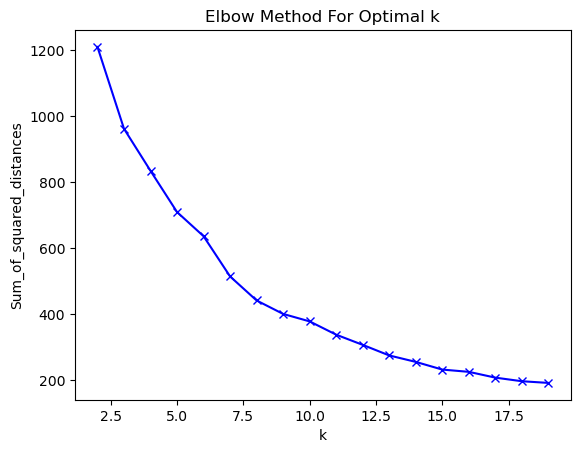

In [53]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

k=8 is the elbow

In [55]:
km_final = KMeans(n_clusters=8)
km_final = km_final.fit(df_user_pivot)

C:\Users\wlgus\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [56]:
km_final.predict(df_user_pivot)

array([7, 1, 6, ..., 3, 1, 7])

In [57]:
df_user_pivot["cluster_number"] = km_final.predict(df_user_pivot)

In [58]:
cluster_result = df_user_pivot.groupby("cluster_number").agg(np.mean)

In [59]:
len(cluster_result.columns)

52

In [60]:
cluster_result.iloc[:,:26]

,first_price_accessories,first_price_apparel,first_price_appliances,first_price_auto,first_price_computers,first_price_construction,first_price_country_yard,first_price_electronics,first_price_furniture,first_price_kids,...,first_price_auto,first_price_computers,first_price_construction,first_price_country_yard,first_price_electronics,first_price_furniture,first_price_kids,first_price_medicine,first_price_sport,first_price_stationery
cluster_number,,,,,,,,,,,,,,,,,,,,,
0,0.000,1.192884e-01,3.525466e-04,0.000000,0.000198,0.000021,0.000000,0.002141,0.000059,0.000253,...,0.000000,0.000198,0.000021,0.000000,0.002141,0.000059,0.000253,0.000000,0.000000,0.000000
1,0.000,4.328903e-07,1.073582e-07,0.000000,0.000000,0.000000,0.000054,0.019322,0.000000,0.000746,...,0.000000,0.000000,0.000000,0.000054,0.019322,0.000000,0.000746,0.000354,0.000367,0.000111
2,0.113,1.358509e-03,2.050868e-04,0.000392,0.001223,0.000000,0.000000,0.001538,0.000934,0.000000,...,0.000392,0.001223,0.000000,0.000000,0.001538,0.000934,0.000000,0.000000,0.000000,0.000000
3,0.000,4.758093e-05,3.145846e-02,0.000000,0.000060,0.000002,0.000000,0.001448,0.000011,0.000092,...,0.000000,0.000060,0.000002,0.000000,0.001448,0.000011,0.000092,0.000000,0.000010,0.000000
4,0.000,2.210703e-04,4.309557e-04,0.081564,0.000155,0.000061,0.000000,0.001683,0.000000,0.000039,...,0.081564,0.000155,0.000061,0.000000,0.001683,0.000000,0.000039,0.000000,0.000385,0.000000
5,0.000,4.452365e-04,8.916189e-04,0.000000,0.000357,0.000000,0.000000,0.002131,0.132210,0.000894,...,0.000000,0.000357,0.000000,0.000000,0.002131,0.132210,0.000894,0.000000,0.000153,0.000000
6,0.000,3.645687e-04,5.791980e-04,0.000000,0.000328,0.073965,0.000000,0.001450,0.000481,0.000135,...,0.000000,0.000328,0.073965,0.000000,0.001450,0.000481,0.000135,0.000000,0.000000,0.000000
7,0.000,0.000000e+00,1.828825e-04,0.000000,0.032022,0.000000,0.000000,0.002496,0.000000,0.000010,...,0.000000,0.032022,0.000000,0.000000,0.002496,0.000000,0.000010,0.000000,0.000101,0.000000


In [61]:
cluster_result.iloc[:,26:]

,count_price_accessories,count_price_apparel,count_price_appliances,count_price_auto,count_price_computers,count_price_construction,count_price_country_yard,count_price_electronics,count_price_furniture,count_price_kids,...,count_price_auto,count_price_computers,count_price_construction,count_price_country_yard,count_price_electronics,count_price_furniture,count_price_kids,count_price_medicine,count_price_sport,count_price_stationery
cluster_number,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.119023,0.001872,0.000000,0.000766,0.000191,0.000000,0.002894,0.000153,0.001149,...,0.000000,0.000766,0.000191,0.000000,0.002894,0.000153,0.001149,0.000000,0.000000,0.000000
1,0.000000,0.000005,0.000003,0.000000,0.000000,0.000000,0.000123,0.023246,0.000000,0.002468,...,0.000000,0.000000,0.000000,0.000123,0.023246,0.000000,0.002468,0.000331,0.001170,0.000368
2,0.513441,0.001792,0.001195,0.001792,0.004779,0.000000,0.000000,0.001828,0.002151,0.000000,...,0.001792,0.004779,0.000000,0.000000,0.001828,0.002151,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000096,0.119344,0.000000,0.000205,0.000027,0.000000,0.001850,0.000043,0.000289,...,0.000000,0.000205,0.000027,0.000000,0.001850,0.000043,0.000289,0.000000,0.000072,0.000000
4,0.000000,0.000216,0.001947,0.345667,0.000541,0.000730,0.000000,0.001967,0.000000,0.000162,...,0.345667,0.000541,0.000730,0.000000,0.001967,0.000000,0.000162,0.000000,0.000325,0.000000
5,0.000000,0.000543,0.004236,0.000000,0.001955,0.000000,0.000000,0.002209,0.213881,0.002444,...,0.000000,0.001955,0.000000,0.000000,0.002209,0.213881,0.002444,0.000000,0.000652,0.000000
6,0.000000,0.000269,0.003367,0.000000,0.001077,0.267273,0.000000,0.002279,0.001212,0.000404,...,0.000000,0.001077,0.267273,0.000000,0.002279,0.001212,0.000404,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.001048,0.000000,0.123045,0.000000,0.000000,0.003064,0.000000,0.000056,...,0.000000,0.123045,0.000000,0.000000,0.003064,0.000000,0.000056,0.000000,0.000224,0.000000
